In [3]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import transformer_lens
except:
    %pip install einops datasets jaxtyping "sae_lens>=3.23.1" tabulate eindex-callum transformer_lens==2.11.0

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}


if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.1/920.1 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━

In [19]:
import sys
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Callable, Literal

import einops

!pip install numpy
import numpy as np
np.recarray
import pandas as pd


import plotly.express as px
import torch as t
from IPython.display import HTML, display
from jaxtyping import Float
from torch import Tensor, nn
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from tqdm.auto import tqdm

device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
section = "part31_superposition_and_saes"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section

# import part31_superposition_and_saes.tests as tests
import part31_superposition_and_saes.utils as utils
from plotly_utils import imshow, line

MAIN = __name__ == "__main__"

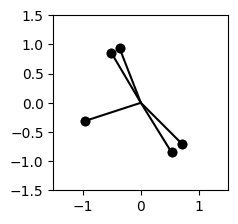

In [20]:
t.manual_seed(2)

W = t.randn(2, 5)
W_normed = W / W.norm(dim=0, keepdim=True)

utils.plot_features_in_2d(
    W_normed.unsqueeze(0),  # shape [instances=1 d_hidden=2 features=5]
)

In [21]:
def linear_lr(step, steps):
    return 1 - (step / steps)


def constant_lr(*_):
    return 1.0


def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class ToyModelConfig:
    n_inst: int
    n_features: int = 5
    d_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0
    feat_mag_distn: Literal["unif", "normal"] = "unif"


class ToyModel(nn.Module):
    W: Float[Tensor, "inst d_hidden feats"]
    b_final: Float[Tensor, "inst feats"]

    def __init__(
        self,
        cfg: ToyModelConfig,
        feature_probability: float | Tensor = 0.01,
        importance: float | Tensor = 1.0,
        device=device,
    ):
        super(ToyModel, self).__init__()
        self.cfg = cfg

        if isinstance(feature_probability, float):
            feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_inst, cfg.n_features))
        if isinstance(importance, float):
            importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_inst, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_inst, cfg.d_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_inst, cfg.n_features)))
        self.to(device)

    def forward(
        self,
        features: Float[Tensor, "... inst feats"],
    ) -> Float[Tensor, "... inst feats"]:
        """
        Performs a single forward pass. For a single instance, this is given by:
            x -> ReLU(W.T @ W @ x + b_final)
        """
        h = einops.einsum(features, self.W, "... inst feats, inst hidden feats -> ... inst hidden")
        out = einops.einsum(h, self.W, "... inst hidden, inst hidden feats -> ... inst feats")
        return F.relu(out + self.b_final)

    def generate_batch(self, batch_size: int) -> Float[Tensor, "batch inst feats"]:
        raise NotImplementedError()

    def calculate_loss(
        self,
        out: Float[Tensor, "batch inst feats"],
        batch: Float[Tensor, "batch inst feats"],
    ) -> Float[Tensor, ""]:
        raise NotImplementedError()

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 5_000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        """
        Optimizes the model using the given hyperparameters.
        """
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:
            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item() / self.cfg.n_inst, lr=step_lr)

In [22]:
def generate_batch(self: ToyModel, batch_size: int) -> Float[Tensor, "batch inst feats"]:
    """
    Generates a batch of data of shape (batch_size, n_instances, n_features).
    """
    batch_shape = (batch_size, self.cfg.n_inst, self.cfg.n_features)
    feat_mag = t.rand(batch_shape, device=self.W.device)
    feat_seeds = t.rand(batch_shape, device=self.W.device)
    return t.where(feat_seeds <= self.feature_probability, feat_mag, 0.0)


ToyModel.generate_batch = generate_batch

In [23]:
def calculate_loss(
    self: ToyModel,
    out: Float[Tensor, "batch inst feats"],
    batch: Float[Tensor, "batch inst feats"],
) -> Float[Tensor, ""]:
    error = self.importance * ((batch - out) ** 2)
    loss = einops.reduce(error, "batch inst feats -> inst", "mean").sum()
    return loss


ToyModel.calculate_loss = calculate_loss

In [26]:
!pip install --upgrade numpy

cfg = ToyModelConfig(n_inst=8, n_features=5, d_hidden=2)

# importance varies within features for each instance
importance = 0.9 ** t.arange(cfg.n_features)

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = 50 ** -t.linspace(0, 1, cfg.n_inst)

line(
    importance,
    width=600,
    height=400,
    title="Importance of each feature (same over all instances)",
    labels={"y": "Feature importance", "x": "Feature"},
)
line(
    feature_probability,
    width=600,
    height=400,
    title="Feature probability (varied over instances)",
    labels={"y": "Probability", "x": "Instance"},
)

model = ToyModel(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 49.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
automated-interpretability 0.0.8 requires numpy<2.0.0,>=1.24.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


  0%|          | 0/5000 [00:00<?, ?it/s]

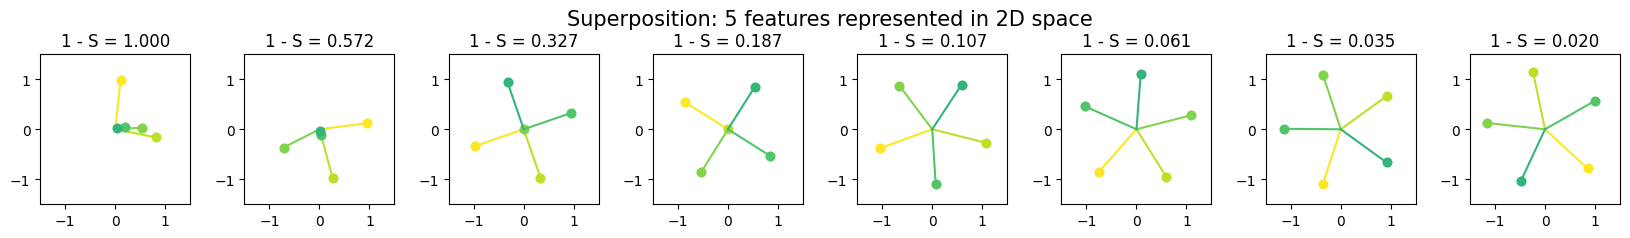

In [27]:
utils.plot_features_in_2d(
    model.W,
    colors=model.importance,
    title=f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles=[f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

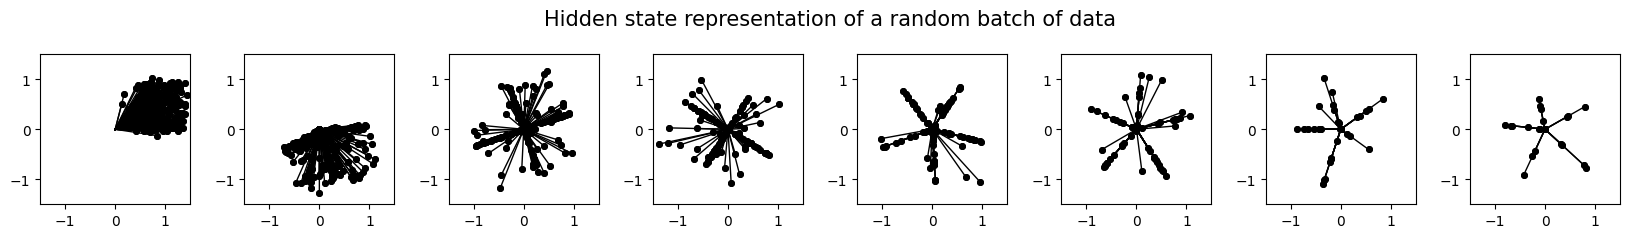

In [28]:
with t.inference_mode():
    batch = model.generate_batch(200)
    hidden = einops.einsum(
        batch,
        model.W,
        "batch instances features, instances hidden features -> instances hidden batch",
    )

utils.plot_features_in_2d(hidden, title="Hidden state representation of a random batch of data")